In [1]:
from stable_baselines_external_data import SBPPORemoteData
import pickle
import numpy as np
from matplotlib import pyplot as plt

import socket
import sys
from multiprocessing import Queue as queue
import pickle
import multiprocessing
import traceback

import gym

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
pickle_files = [
    "_setme_policy_player_1_step4acfc3f0-f162-11ea-a8ee-00155dd0a349.pkl"
#    "00ae3134-f14f-11ea-979b-00155dd0a349_policy_player_1_step1743c792-f14f-11ea-98db-00155dd0a349.pkl",
#    "cb588fc6-f14d-11ea-97f2-00155dd0a349_policy_player_1_step053aae4a-f14e-11ea-9b00-00155dd0a349.pkl",
#     "8885fb54-f146-11ea-9c48-00155dd0a349_policy_player_1_step9f4fac72-f146-11ea-8134-00155dd0a349.pkl",
#     "8885fb54-f146-11ea-9c48-00155dd0a349_policy_player_1_stepbde36688-f146-11ea-82ae-00155dd0a349.pkl",
#     "8885fb54-f146-11ea-9c48-00155dd0a349_policy_player_1_stepda4f5b4c-f146-11ea-847f-00155dd0a349.pkl",
#     "8885fb54-f146-11ea-9c48-00155dd0a349_policy_player_1_stepf6b5ad7c-f146-11ea-a591-00155dd0a349.pkl",
#     "e58349de-f140-11ea-9170-00155dd0a349_policy_player_1_step4272133c-f141-11ea-bde7-00155dd0a349.pkl",
#     "e58349de-f140-11ea-9170-00155dd0a349_policy_player_1_step5aebe492-f141-11ea-a3cf-00155dd0a349.pkl",
#     "e58349de-f140-11ea-9170-00155dd0a349_policy_player_1_step74425e6c-f141-11ea-b539-00155dd0a349.pkl",
]

In [3]:
inputs = {fn: pickle.load(open(fn, 'rb')) for fn in pickle_files}
outputs = {fn: pickle.load(open(fn[:-len('.pkl')] + '_answer.pkl', 'rb')) for fn in pickle_files}

In [4]:
# checking that weights input[i+1] = output[i]
for i in range(len(inputs) - 1):
    d1, d2 = inputs[pickle_files[i + 1]]['weights'], outputs[pickle_files[i]]['weights']
    assert d1.keys() == d2.keys()
    for k in d1.keys():
        assert np.allclose(d1[k], d2[k])
    print(i, "passed")

In [5]:
inp = inputs[pickle_files[0]]

In [6]:
config = inp['config']

In [11]:
sbppo = SBPPORemoteData(config=config)
sbppo.set_weights(inp['weights'])
info = sbppo.learn(inp['rollouts'])
#sbppo.set_weights(inp['weights']
#sbppo.set_weights(outputs[pickle_files[0]]['weights'])

Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
-------------------------------------
| approxkl           | 0.009773739  |
| clipfrac           | 0.04950837   |
| explained_variance | -0.00534     |
| fps                | 12625        |
| n_updates          | 1            |
| policy_entropy     | 24.137663    |
| policy_loss        | -0.028445758 |
| serial_timesteps   | 6509         |
| time_elapsed       | 1.36e-05     |
| total_timesteps    | 0            |
| value_loss         | 13.478839    |
-------------------------------------


In [18]:
for _ in range(100):
    info = sbppo.learn(inp['rollouts'])


------------------------------------
| approxkl           | 0.079003856 |
| clipfrac           | 0.5212782   |
| explained_variance | -0.00534    |
| fps                | 16037       |
| n_updates          | 1           |
| policy_entropy     | 24.091856   |
| policy_loss        | -0.16534346 |
| serial_timesteps   | 6509        |
| time_elapsed       | 1.41e-05    |
| total_timesteps    | 0           |
| value_loss         | 13.008823   |
------------------------------------
------------------------------------
| approxkl           | 0.08319762  |
| clipfrac           | 0.5495852   |
| explained_variance | -0.00534    |
| fps                | 17750       |
| n_updates          | 1           |
| policy_entropy     | 24.086441   |
| policy_loss        | -0.17144224 |
| serial_timesteps   | 6509        |
| time_elapsed       | 1.36e-05    |
| total_timesteps    | 0           |
| value_loss         | 12.997843   |
------------------------------------
------------------------------------
|

In [8]:
self = sbppo.ppo.act_model


res = self.sess.run(sbppo.ppo.act_model.action, feed_dict={self.obs_ph: .01*np.ones((50000, 380))})

(array([   24.,   241.,  1932.,  7154., 14167., 15043.,  8424.,  2558.,
          413.,    44.]),
 array([-4.9856644 , -4.1692243 , -3.352784  , -2.5363438 , -1.7199037 ,
        -0.9034635 , -0.0870233 ,  0.72941685,  1.5458571 ,  2.3622973 ,
         3.1787374 ], dtype=float32),
 <a list of 10 Patch objects>)

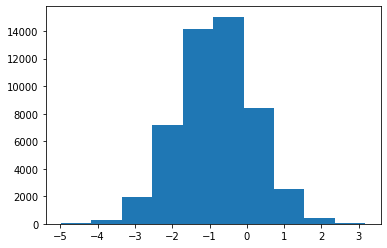

In [52]:
plt.hist(res[:, 3])

In [53]:
np.std(res[:, 3])

1.0008113

In [54]:
sbppo.ppo.action_probability(observation=np.ones((1, 380))* 0.01, actions=0.01 * np.ones((1, 17)))

array([[1.44048945e-11]])

In [101]:
ao = pickle.load(open('ao.pkl', 'rb'))

In [112]:
self = sbppo.ppo.act_model


res1 = self.sess.run(sbppo.ppo.act_model.neglogp, feed_dict={self.obs_ph: ao['o'],
                                                             self.action: ao['a']
                                                            })
#logl1 = sbppo.ppo.action_probability(observation=ao['o'], actions=ao['a'])

In [113]:
pickle.dump(res1, open('logl_sb.pkl', 'wb'))

In [106]:
np.log(logl1)

array([[-27.65403808],
       [-27.24515292],
       [-29.48765788],
       ...,
       [-28.24122234],
       [-27.45615706],
       [-25.58718336]])

In [109]:
self = sbppo.ppo.act_model


res1 = self.sess.run(sbppo.ppo.act_model.neglogp, feed_dict={self.obs_ph: ao['o'],
                                                             self.action: ao['a']
                                                            })

In [110]:
res1

array([25.222132, 24.08613 , 30.193739, ..., 26.81917 , 24.710402,
       19.60248 ], dtype=float32)

In [26]:
self = sbppo.ppo.act_model


self.sess.run(sbppo.ppo.act_model.policy, feed_dict={self.obs_ph: np.ones((1, 380))})

array([[ 0.33781117, -0.6387095 ,  0.28466988, -0.324178  ,  1.0578278 ,
        -0.2268597 , -0.48037216,  0.3405744 , -0.4707465 , -0.4581374 ,
         1.4834704 ,  0.3253918 ,  0.14506464, -0.8816432 , -1.3016344 ,
         0.69646215, -0.15551722]], dtype=float32)

In [ ]:
# mean is correct!!!

In [24]:
outputs[pickle_files[0]]['weights']['logstd:0']

array([[-0.00116918,  0.00082356, -0.00108885,  0.00095606, -0.00118329,
         0.0008741 ,  0.00041932,  0.00079433, -0.00011316, -0.00083624,
        -0.00062921,  0.00017351,  0.00025134, -0.00053647,  0.00087864,
        -0.00020972, -0.0006326 ]], dtype=float32)

In [25]:
self = sbppo.ppo.act_model


self.sess.run(sbppo.ppo.act_model.logstd, feed_dict={self.obs_ph: np.ones((1, 380))})

array([[-0.00116918,  0.00082356, -0.00108885,  0.00095606, -0.00118329,
         0.0008741 ,  0.00041932,  0.00079433, -0.00011316, -0.00083624,
        -0.00062921,  0.00017351,  0.00025134, -0.00053647,  0.00087864,
        -0.00020972, -0.0006326 ]], dtype=float32)

In [295]:
obs1, returns1, masks1, actions1, values1, neglogpacs1, states1, ep_infos1, true_reward1 = sbppo.ppo.runner.run()

Calling run() twice


In [296]:
sbppo.ppo.action_probability(obs1[100], actions=actions1[100])

array([1.9493823e-12], dtype=float32)

In [297]:
sbppo.env_orig.action_space[0].high[0]

0.4

In [298]:
sbppo.env_orig.observation_space[0].high[0]

inf

In [299]:
inp['rollouts'].keys()

dict_keys(['t', 'eps_id', 'agent_index', 'obs', 'actions', 'rewards', 'prev_actions', 'prev_rewards', 'dones', 'infos', 'new_obs', 'action_prob', 'action_logp', 'action_dist_inputs', 'vf_preds', 'unroll_id', 'advantages', 'value_targets'])

In [300]:
sbppo.ppo.value(np.array([inp['rollouts']['obs'][0]]))

array([2.331657], dtype=float32)

In [301]:
sbppo.ppo.predict(obs1[0])

(array([ 0.4       , -0.2870105 , -0.4       , -0.4       ,  0.4       ,
         0.4       , -0.4       , -0.4       , -0.33435982, -0.4       ,
         0.4       , -0.11857797,  0.4       ,  0.18337083, -0.4       ,
         0.4       ,  0.4       ], dtype=float32),
 None)

In [302]:
actions1[0]

array([ 1.5958313 ,  0.7703866 , -0.54719126, -1.9976833 ,  1.6901374 ,
       -0.23313254, -1.3133931 , -1.5083477 , -0.38309667,  1.3615172 ,
        0.5574909 ,  0.18588221,  0.92212176, -1.5762848 ,  0.53522336,
        0.99442494,  0.4619234 ], dtype=float32)

In [303]:
sbppo.ppo

In [304]:
sbppo.ppo.predict(obs1[0])

(array([-0.4       , -0.4       ,  0.1893939 , -0.4       , -0.4       ,
         0.4       , -0.4       , -0.4       ,  0.29169214,  0.21761435,
         0.4       , -0.4       , -0.4       , -0.4       ,  0.4       ,
        -0.4       , -0.4       ], dtype=float32),
 None)

In [357]:
sbppo.set_weights(inp['weights'])

In [306]:
25.000622 

25.000622

In [307]:
# clipping actions
inp['rollouts']['actions_unclipped'] = np.copy(inp['rollouts']['actions'])
#inp['rollouts']['actions'] = np.clip(inp['rollouts']['actions'], sbppo.env_orig.action_space[0].low, sbppo.env_orig.action_space[0].high)
inp['rollouts']['true_neglogp'] = -np.log(sbppo.ppo.action_probability(inp['rollouts']['obs'], actions=inp['rollouts']['actions']))[:, 0]

In [308]:
inp['rollouts']['true_neglogp'].shape

(21576,)

In [309]:
np.log(2.126762e-11) / np.log(10)

-10.67228110806152

In [360]:
import tensorflow as tf

In [400]:
self = sbppo.ppo.act_model


self.sess.run(sbppo.ppo.act_model.policy, feed_dict={self.obs_ph: np.ones((1, 380))})

array([[ 0.97888553,  0.9474181 ,  0.26245996, -0.24640836,  0.46941692,
        -0.40494165,  0.672592  , -0.52557856,  0.5032894 ,  0.300472  ,
        -0.2419817 , -0.7371399 , -0.4276322 , -0.71516854, -0.32882518,
         0.35076812, -0.9474809 ]], dtype=float32)

In [392]:
inp['weights']['logstd:0']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [366]:
with tf.variable_scope("input"):
    print(sbppo.ppo.act_model.sess.run(sbppo.ppo.act_model.action))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [152]:
def swap_and_flatten(arr):
    """
    swap and then flatten axes 0 and 1

    :param arr: (np.ndarray)
    :return: (np.ndarray)
    """
    shape = arr.shape
    return arr.swapaxes(0, 1).reshape(shape[0] * shape[1], *shape[2:])


class mock_vanilla_runner():
    def __init__(self, rollouts, weights, env, true_model, gamma, lam):
        self.rollouts = rollouts
        self.states = None
        self.dones = self.rollouts['dones'][0:1]
        self.true_env = env
        self.true_model = true_model
        self.gamma = gamma
        self.lam = lam
        
        class model_cls(object):
            def __init__(self, rollouts, true_model):
                self.rollouts = rollouts
                self.true_model = true_model
                self.idx = 0
                self.num_timesteps = 0
            def step(self, obs, states, dones):
                states = None
                actions = self.rollouts['actions'][self.idx]
                values = self.rollouts['vf_preds'][self.idx]
                #value_true = self.true_model.value(np.array([obs]))[0]
                #actions_unclip = self.rollouts['actions'][self.idx-1]
                #actions_unclip = self.rollouts['actions_unclipped'][self.idx]
                #neglogpac_true = -np.log(sbppo.ppo.action_probability(obs, actions=actions_unclip)[0])
                #if np.linalg.norm(values - value_true) > 1e-5:
                #    print("Wrong value", values, value_true)
                    
                neglogpacs = -self.rollouts['action_logp'][self.idx]
                #neglogpacs = self.rollouts['true_neglogp'][self.idx]
                
                #if np.linalg.norm(neglogpacs - neglogpac_true) > 1e-3 and dones:
                #    print("Wrong NegLogP", neglogpacs, neglogpac_true)
                
                self.idx += 1
                return np.array([actions]), np.array([values]), np.array([states]), np.array([neglogpacs])
            def value(self, obs, states, dones):
                return np.array([self.rollouts['vf_preds'][-1]])
            
        class env_cls(object):
            def __init__(self, rollouts, true_env):
                self.true_env = true_env
                self.rollouts = rollouts
                self.action_space = true_env.action_space
                self.observation_space = true_env.observation_space
                self.idx = 0
            def reset(self):
                self.idx += 1
                return np.array([self.rollouts['obs'][0]])
            
            def step(self, actions):
                #print(actions, self.rollouts['actions'][self.idx - 1])
                #assert np.allclose(actions, self.rollouts['actions'][self.idx - 1])
                obs = self.rollouts['obs'][self.idx]
                rew = self.rollouts['rewards'][self.idx]
                done = self.rollouts['dones'][self.idx]
                info = self.rollouts['infos'][self.idx]
                self.idx += 1
                return np.array([obs]), np.array([rew]), np.array([done]), np.array([info])
            
        self.model = model_cls(self.rollouts, self.true_model)
        self.env = env_cls(self.rollouts, self.true_env)
        
        self.obs = self.env.reset()
        self.n_envs = 1
        self.callback = None
        self.n_steps = len(self.rollouts['obs']) - 1
        

    def vanilla_run(self):
        # mb stands for minibatch
        mb_obs, mb_rewards, mb_actions, mb_values, mb_dones, mb_neglogpacs = [], [], [], [], [], []
        mb_states = self.states
        ep_infos = []
        for _ in range(self.n_steps):
            actions, values, self.states, neglogpacs = self.model.step(self.obs, self.states, self.dones)
            mb_obs.append(self.obs.copy())
            mb_actions.append(actions)
            mb_values.append(values)
            mb_neglogpacs.append(neglogpacs)
            mb_dones.append(self.dones)
            clipped_actions = actions
            # Clip the actions to avoid out of bound error
            if isinstance(self.env.action_space, gym.spaces.Box):
                clipped_actions = np.clip(actions, self.env.action_space.low, self.env.action_space.high)
            self.obs[:], rewards, self.dones, infos = self.env.step(clipped_actions)

            self.model.num_timesteps += self.n_envs

            if self.callback is not None:
                # Abort training early
                if self.callback.on_step() is False:
                    self.continue_training = False
                    # Return dummy values
                    return [None] * 9

            for info in infos:
                maybe_ep_info = info.get('episode')
                if maybe_ep_info is not None:
                    ep_infos.append(maybe_ep_info)
            mb_rewards.append(rewards)
                        
        # batch of steps to batch of rollouts
        mb_obs = np.asarray(mb_obs, dtype=self.obs.dtype)
        mb_rewards = np.asarray(mb_rewards, dtype=np.float32)
        mb_actions = np.asarray(mb_actions)
        mb_values = np.asarray(mb_values, dtype=np.float32)
        mb_neglogpacs = np.asarray(mb_neglogpacs, dtype=np.float32)
        mb_dones = np.asarray(mb_dones, dtype=np.bool)
        last_values = self.model.value(self.obs, self.states, self.dones)
        # discount/bootstrap off value fn
        mb_advs = np.zeros_like(mb_rewards)
        true_reward = np.copy(mb_rewards)
        last_gae_lam = 0
        for step in reversed(range(self.n_steps)):
            if step == self.n_steps - 1:
                nextnonterminal = 1.0 - self.dones
                nextvalues = last_values
            else:
                nextnonterminal = 1.0 - mb_dones[step + 1]
                nextvalues = mb_values[step + 1]
            delta = mb_rewards[step] + self.gamma * nextvalues * nextnonterminal - mb_values[step]
            mb_advs[step] = last_gae_lam = delta + self.gamma * self.lam * nextnonterminal * last_gae_lam
        mb_returns = mb_advs + mb_values

        
        
        mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs, true_reward = \
            map(swap_and_flatten, (mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs, true_reward))
        return mb_obs, mb_returns, mb_dones, mb_actions, mb_values, mb_neglogpacs, mb_states, ep_infos, true_reward
            

In [153]:
mvr = mock_vanilla_runner(inp['rollouts'], inp['weights'], sbppo.env, sbppo.ppo, sbppo.ppo.gamma, sbppo.ppo.lam)

In [154]:
obs2, returns2, masks2, actions2, values2, neglogpacs2, states2, ep_infos2, true_reward2 = mvr.vanilla_run()

In [156]:
obs2.shape

(6509, 380)

In [317]:
np.allclose(actions1[:-1], actions2)

True

In [318]:
# observations are fine
np.sum(np.linalg.norm(obs1[:-1] - obs2, axis=1) > 0)

1

In [319]:
# returns are not fine
returns1[:-1] - returns2

array([ 2.2823048,  2.3053582,  2.3286448, ...,  9.801001 ,  9.9      ,
       10.       ], dtype=float32)

In [320]:
# dones are fine
np.allclose(masks1[:-1], masks2)

True

In [321]:
# need to start from 1
np.sum((true_reward1[1:] - true_reward2) > 0)

0

In [322]:
# logs are different
neglogpacs1, neglogpacs2

(array([23.447   , 21.135674, 22.363998, ..., 25.202456, 21.901691,
        28.671139], dtype=float32),
 array([27.00063 , 26.15034 , 26.602215, ..., 27.571606, 27.646423,
        26.432142], dtype=float32))

In [323]:
# values are fine!
np.sum(np.abs(values1[:-1] - values2) > 0)

0

In [ ]:
1. clip actions +
2. normalize values +
3. logprob -- action not clipped?

In [ ]:
class MultipleWorker(object):
    """Handles multiple workers identified by IDs."""
    
    def __init__(self):
        """Initialize with zero workers."""
        self.workers = set()
        self.kwargs_queues = {}
        self.return_queues = {}
        self.worker_processes = {}
        assert hasattr(self, '_process_fcn'), "Please implement _process_fcn"
        self._process_init()
        
    def target_process(self, worker_id):
        """Process to run in each worker."""
        #print("Starting process", worker_id)
        while True:
            kwargs = pickle.loads(self.kwargs_queues[worker_id].get())
            try:
                result = self._process_fcn(**kwargs, worker_id=worker_id)
            except Exception as e:
                result = ("Exception", traceback.format_exc())
                pass
            self.return_queues[worker_id].put(pickle.dumps(result))
            
    def _process_init(self):
        """Initialize client code."""
        pass
            
    def _process_fcn(self, **kwargs):
        """Process function, to be implemented."""
        #print("Called with:", kwargs)
        return str(kwargs)
        
    def new_worker(self, worker_id):
        """Create a worker with a given ID."""
        if worker_id in self.workers:
            return
        else:
            self.workers.add(worker_id)
            self.kwargs_queues[worker_id] = queue()
            self.return_queues[worker_id] = queue()
            self.worker_processes[worker_id] = multiprocessing.Process(target=self.target_process,
                                                                       kwargs=dict(worker_id=worker_id))
            self.worker_processes[worker_id].start()
            
    def process(self, worker_id, kwargs):
        """Process a request."""
        if worker_id not in self.workers:
            print("Creating worker", worker_id)
            self.new_worker(worker_id)
        self.kwargs_queues[worker_id].put(pickle.dumps(kwargs))
        res = self.return_queues[worker_id].get()
        return pickle.loads(res)
    
    def __del__(self):
        """Close all processes."""
        for p in self.worker_processes.values():
            p.kill()
            
class MultiStepTrainer(object):
    """Train with stable baselines on external data, supporting multiple trainers."""
    def __init__(self):
        self.trainers = {}
    def create(self, uid, config):
        if uid in self.trainers:
            print("Trainer %s already exists, doing nothing" % uid)
        else:
            self.trainers[uid] = SBPPORemoteData(config=config)
    def process(self, uid, rollouts, weights):
        if uid not in self.trainers:
            print("Error: trainer %s does not exist" % uid)
            return None
        
        self.trainers[uid].set_weights(weights)
        info = self.trainers[uid].learn(rollouts)
        new_weights = self.trainers[uid].get_weights()
        return {'info': info, 'weights': new_weights}
            
class MultipleWorkerTrainer(MultipleWorker):
    """Train with multiple workers."""
    
    def _process_init(self):
        self.trainer = None
    
    def _process_fcn(self, uid, config, data_path, answer_path, worker_id):
        if self.trainer is None:
            self.trainer = MultiStepTrainer()
        self.trainer.create(uid, config)
        data = pickle.load(open(data_path, 'rb'))
        rollouts = data['rollouts']
        weights = data['weights']
        
        result = self.trainer.process(uid, rollouts, weights)
        
        pickle.dump(result, open(answer_path, 'wb'))
        return True

In [5]:
from asgiref.sync import async_to_sync
from tornado import ioloop, web
from jsonrpcserver import method, dispatch as dispatch, serve
import argparse

parser = argparse.ArgumentParser(description='Launch the multiprocess stable baselines server.')
parser.add_argument('--port', metavar='N', default=1234,
                    help='port to listen on')


# Server for DatabasePreferenceLearner
class MainHandler(web.RequestHandler):
    def post(self):
        request = self.request.body.decode()
        print(request)
        response = dispatch(request)
        print(response)
        if response.wanted:
            self.write(str(response))

app = web.Application([(r"/", MainHandler)])
trainer = None
            
def run_server(port=50001):
    """Run server."""

    print("Listening on port %d" % port)

    global trainer
    trainer = MultipleWorkerTrainer()

    @method
    def process(*args, **kwargs):
        global trainer
        return trainer.process(*args, **kwargs)
    serve(port=port)

if __name__ == "__main__":
    args = parser.parse_args()
    run_server(port=8899)

usage: ipykernel_launcher.py [-h] [--port N]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/sergei/.local/share/jupyter/runtime/kernel-4c365b2d-38a4-465f-9ade-8ae6738116b6.json


SystemExit: 2

In [6]:
run_server()

Listening on port 50001
Creating worker aba_policy_player_1
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


-----------------------------------
| approxkl           | 0.06915925 |
| clipfrac           | 0.52264327 |
| explained_variance | -6.38      |
| fps                | 1372       |
| n_updates          | 1          |
| policy_entropy     | 24.122137  |
| policy_loss        | -0.1785963 |
| serial_timesteps   | 628        |
| time_elapsed       | 2.62e-05   |
| total_timesteps    | 628        |
| value_loss         | 28006.676  |
-----------------------------------
Creating worker aba_policy_player_2


127.0.0.1 - - [07/Sep/2020 00:24:37] "POST / HTTP/1.1" 200 -


Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


------------------------------------
| approxkl           | 0.13145663  |
| clipfrac           | 0.6714968   |
| explained_variance | -3.05       |
| fps                | 1319        |
| n_updates          | 1           |
| policy_entropy     | 2.6566029   |
| policy_loss        | -0.18494165 |
| serial_timesteps   | 628         |
| time_elapsed       | 2.79e-05    |
| total_timesteps    | 628         |
| value_loss         | 143010.02   |
------------------------------------


127.0.0.1 - - [07/Sep/2020 00:24:39] "POST / HTTP/1.1" 200 -


Trainer 0 already exists, doing nothing
-----------------------------------
| approxkl           | 0.08314504 |
| clipfrac           | 0.52       |
| explained_variance | -6.45      |
| fps                | 2261       |
| n_updates          | 1          |
| policy_entropy     | 24.11175   |
| policy_loss        | -0.1782296 |
| serial_timesteps   | 651        |
| time_elapsed       | 1.41e-05   |
| total_timesteps    | 651        |
| value_loss         | 17387.547  |
-----------------------------------
Trainer 0 already exists, doing nothing


127.0.0.1 - - [07/Sep/2020 00:26:19] "POST / HTTP/1.1" 200 -


------------------------------------
| approxkl           | 0.1687577   |
| clipfrac           | 0.65757287  |
| explained_variance | -4.34       |
| fps                | 2316        |
| n_updates          | 1           |
| policy_entropy     | 2.6631653   |
| policy_loss        | -0.19491127 |
| serial_timesteps   | 651         |
| time_elapsed       | 1.53e-05    |
| total_timesteps    | 651         |
| value_loss         | 177388.5    |
------------------------------------


127.0.0.1 - - [07/Sep/2020 00:26:19] "POST / HTTP/1.1" 200 -


Trainer 0 already exists, doing nothing
------------------------------------
| approxkl           | 0.09739331  |
| clipfrac           | 0.5525522   |
| explained_variance | -6.02       |
| fps                | 2475        |
| n_updates          | 1           |
| policy_entropy     | 24.11979    |
| policy_loss        | -0.17488614 |
| serial_timesteps   | 623         |
| time_elapsed       | 1.57e-05    |
| total_timesteps    | 623         |
| value_loss         | 12023.959   |
------------------------------------
Trainer 0 already exists, doing nothing


127.0.0.1 - - [07/Sep/2020 00:27:09] "POST / HTTP/1.1" 200 -


------------------------------------
| approxkl           | 0.21780328  |
| clipfrac           | 0.72028893  |
| explained_variance | -3.41       |
| fps                | 2232        |
| n_updates          | 1           |
| policy_entropy     | 2.6520212   |
| policy_loss        | -0.21072704 |
| serial_timesteps   | 623         |
| time_elapsed       | 1.5e-05     |
| total_timesteps    | 623         |
| value_loss         | 189153.66   |
------------------------------------


127.0.0.1 - - [07/Sep/2020 00:27:09] "POST / HTTP/1.1" 200 -


Trainer 0 already exists, doing nothing
-----------------------------------
| approxkl           | 0.1215145  |
| clipfrac           | 0.616332   |
| explained_variance | -6.91      |
| fps                | 2260       |
| n_updates          | 1          |
| policy_entropy     | 24.116104  |
| policy_loss        | -0.1870755 |
| serial_timesteps   | 518        |
| time_elapsed       | 1.55e-05   |
| total_timesteps    | 518        |
| value_loss         | 17239.387  |
-----------------------------------
Trainer 0 already exists, doing nothing


127.0.0.1 - - [07/Sep/2020 00:27:52] "POST / HTTP/1.1" 200 -


------------------------------------
| approxkl           | 0.28200954  |
| clipfrac           | 0.73664093  |
| explained_variance | -3.84       |
| fps                | 2104        |
| n_updates          | 1           |
| policy_entropy     | 2.6567543   |
| policy_loss        | -0.21154171 |
| serial_timesteps   | 518         |
| time_elapsed       | 1.88e-05    |
| total_timesteps    | 518         |
| value_loss         | 179554.92   |
------------------------------------


127.0.0.1 - - [07/Sep/2020 00:27:52] "POST / HTTP/1.1" 200 -
Process Process-3:
Process Process-2:
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/sergei/miniconda3/envs/tf1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sergei/miniconda3/envs/tf1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sergei/miniconda3/envs/tf1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sergei/miniconda3/envs/tf1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-d8eddcf039a3>", line 17, in target_process
    kwargs = pickle.loads(self.kwargs_queues[worker_id].get())
  File "<ipython-input-2-d8eddcf039a3>", line 17, in target_process
    kwargs = pickle.loads(self.kwargs_queues[worker_id].get())
  File "/home/sergei/miniconda3/envs/tf1/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/sergei/miniconda3/envs/

In [7]:
data = pickle.load(open('rollout.pkl', 'rb'))

In [8]:
mst = MultiStepTrainer()
config = data['config']

In [9]:
new_weights = {}
for player in data['policies'].keys():
    uid = str(data['uid']) + '/' + player
    weights = data['weights_dict'][player]
    rollout = data['samples'][player]
    print(len(rollout['t']), config['train_batch_size'])
    mst.create(uid=uid, config=config)
    new_weights[player] = mst.process(uid=uid, rollouts=rollout, weights=weights)

65071 50000
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
-------------------------------------
| approxkl           | 0.022438252  |
| clipfrac           | 0.14191274   |
| explained_variance | -5.93        |
| fps                | 4508         |
| n_updates          | 1            |
| policy_entropy     | 24.084276    |
| policy_loss        | -0.054289613 |
| serial_timesteps   | 65070        |
| time_elapsed       | 3.12e-05     |
| total_timesteps    | 65070        |
| value_loss         | 4455.2646    |
-------------------------------------
65071 50000
Creating agent humanoid_blocker
Readin

In [13]:
!du -s --si rollout.pkl

459M	rollout.pkl
